# <center>Автоматизация процесса идентификации по возрасту</center>


Для повышения эффективности работы магазина было предложено протестировать систему автоматической возрастной оценки покупателей. Это позволит отслеживать незаконные продажи

### Основная цель: получить прототип модели распознавания возраста по изображению

Для реализации данной цели, мы выделили следующие задачи:

1) Провести исследовательский анализ данных: 
- Оценить образцы данных

- Оценить возрастной состав выборки

2) Провести анализ и обучение модели

- Выбрать архитектуру

- Провести обучение

- Оценить результаты и возможность переобучения/недообучения

3) Сделать выводы



# План

В связи с запросами заказчика перед нами стоит задача исследовательского анализа данных. Также статистическая оценка значимости различий.

## <a id='start'>Содержание</a>

### [Exploratory Data Analysis](#eda)

* [Загрузка данных](#loading)

* [Оценка распределения](#dist)

* [Образцы данных](#sample)

### [Neural network](#nn)

* [Выбор модели](#models)

* [Код обучения](#code)

* [Результаты обучения](#result)


### [Финальный вывод](#summary)




# <a id='eda'>1. Исследовательский анализ данных</a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## <a id='loading'>Загрузка выборки</a>

**С помощью загрузчика данных импортируем первый батч наших данных и сводим с его целевым возрастом**

***Размер батча - 32 изображения***

In [10]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
features, target = next(train_gen_flow)

## <a id='dist'>Распределения возраста внутри нашей выборки (батча):</a>

In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


[Text(0, 0.5, 'Количество'),
 Text(0.5, 0, 'Возраст'),
 Text(0.5, 1.0, 'Распределение возрастов в выборке')]

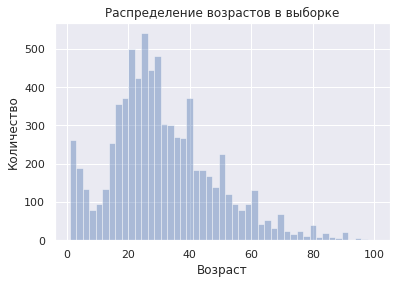

In [9]:
sns.set()

ax = sns.distplot(a = labels['real_age'], kde=False)
ax.set(title = "Распределение возрастов в выборке", ylabel='Количество', xlabel='Возраст')            



In [11]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Выборка содержит разметку значений в диапазоне (0;100].

Распределение не является нормальным и сбалансированным. Больше всего значений распределено в возрасте 20-30.

Неравномерность распределения между возрастами продиктована характером интересующей наш величины - дискретная величина в абсолютной шкале.


***Мы предполагаем, что на таком объеме наша выборка возможно потребует коррекции для улучшения качества модели на следующих итерациях.***

## <a id='sample'>Образец наших изображений</a>

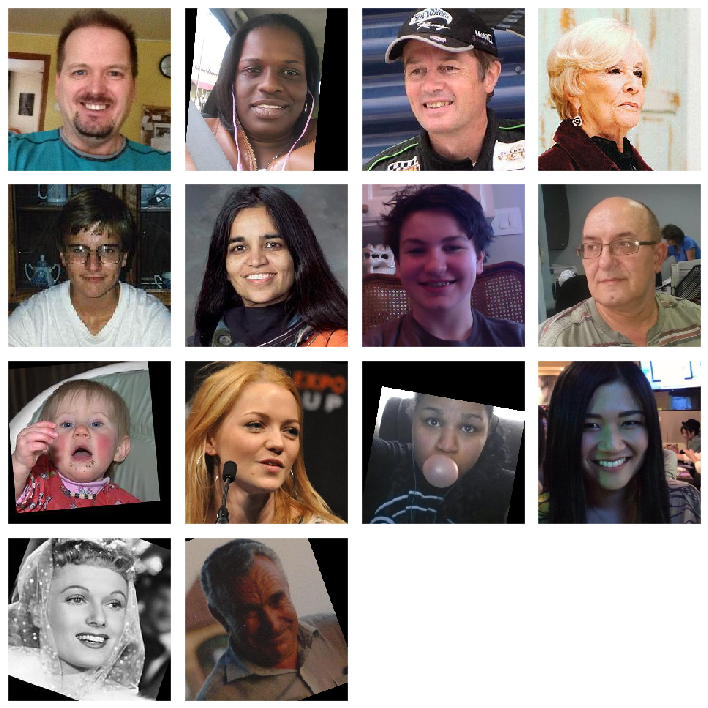

In [5]:

fig = plt.figure(figsize=(10,10))
for i in range(14):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Образец показывает, что изображения:

*  различны;

*  выполнены под разными углами;

*  имеют разное качество (чб/цветные);

* имеют фоновый шум (препятствия/освещенность)

**В связи с этим, мы можем предположить, что аугментация в процессе обучения не потребуется**


***Выводы по исследовательской части:***

В ходе разведочного анализа данных мы оценили распределение возрастов на примере одного из наших батчей, а также просмотрели образцы изображений.

Это приводит нас к выводу, что наши данные пригодны для обучения модели машинного обучения.

# <a id='nn'>2. Обучение модели</a>

- Задача машинного обучения может быть сформулирована **регрессию** (предсказания некой числовой величины).

- Для работы с изображениями мы вынуждены задействовать нейронные сети, как наиболее эффективные при работе с изображениями.

- Для обучения нейронных сетей "с нуля" требуются большие массивы данных, которыми мы не обладаем.

- Наиболее эффективной для экспериментов нам представляется использования фреймворка TensorFlow, который обладает предобученными моделями, а также может быть легко перенесен в продакшен.

- Перспективная предобученная модель - ResNet50, архитектура - сверточная нейронная сеть ResNet


**Таким образом, мы вынуждены для обеспечения высокого качества использовать уже предобученную модель Resnet50 из API Tensorflow Keras для работы с изображениями.**

***Обучение будет производится на выделенном серверном GPU***

## <a id='code'>Код обучения</a>

```python
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
 
 
def load_train(path):
 
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)

    directory = path + '/final_files/'
    labels = pd.read_csv(path + '/labels.csv')

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_datagen_flow 
 
 
def load_test(path):
 
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)
    directory = path + '/final_files/'
    labels = pd.read_csv(path + '/labels.csv')
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_datagen_flow 
 
 
def create_model(input_shape):
 
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu'))
 
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    model.summary()
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
            steps_per_epoch = len(train_data)
    if validation_steps is None:
            validation_steps = len(test_data)
 
    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model
    
```

```python
print("Hello world!")
```

Спасибо! Про такое форматирование ещё не знал!..

## <a id='result'>Результат обучения</a>

Наша модель показала впечатляющий результат средней абсолютной ошибки - **6.2 лет** на валидационной выборке при требованиях в 7 лет.

Обучение модели заняло менее **30 мин.**

# <a id='summary'>3. Анализ обученной модели</a>

Результаты обоих этапах приводят нас к нескольким важным выводам:

- В ходе исследовательского анализа данных, мы предположили, что наша выборка изображений является пригодной для тестирования нейронной сети.

- В связи с ограниченностью наших объемов данных, мы использовали предобученную модель ResNet на ImageNet, которая позволила нам обойти это ограничение

- Получившаяся модель показала хороший результат на валидационной выборке - 6.2 абсолютной ошибки (MAE), это означает, что наша модель ошибается на ±6 лет в ходе предсказаний.

- Результаты целевой метрики - MSE - отличаются на тренировочной и валидационной выборке, однако нет серьезных провалов по качеству на валидации. Таким образом, мы можем заключить, что избежали проблемы переобучения.

Наша модель показала **эффективность** такого подхода. На второй итерации, мы можем задействовать большую выборку для улучшения качества.

[<center>В начало</center>](#start)